In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
query = '''
SELECT 
    f.film_id, 
    f.title, 
    f.release_year, 
    f.rental_duration, 
    f.length, 
    f.rating, 
    f.special_features, 
    COUNT(r.rental_id) AS num_rentals, 
    AVG(DATEDIFF(r.return_date, r.rental_date)) AS avg_rental_duration, 
    AVG(p.amount) AS avg_rental_rate
FROM 
    film f
LEFT JOIN 
    inventory i ON f.film_id = i.film_id
LEFT JOIN 
    rental r ON i.inventory_id = r.inventory_id AND r.rental_date >= '2005-05-01' AND r.rental_date < '2005-06-01'
LEFT JOIN 
    payment p ON r.rental_id = p.rental_id
GROUP BY 
    f.film_id;
'''
data = pd.read_sql_query(query, engine)
data

,film_id,title,release_year,rental_duration,length,rating,special_features,num_rentals,avg_rental_duration,avg_rental_rate
0,1,ACADEMY DINOSAUR,2006,6,86,PG,"Deleted Scenes,Behind the Scenes",2,5.5000,1.49
1,2,ACE GOLDFINGER,2006,3,48,G,"Trailers,Deleted Scenes",0,NaN,NaN
2,3,ADAPTATION HOLES,2006,7,50,NC-17,"Trailers,Deleted Scenes",1,2.0000,2.99
3,4,AFFAIR PREJUDICE,2006,5,117,G,"Commentaries,Behind the Scenes",2,6.0000,3.99
4,5,AFRICAN EGG,2006,6,130,G,Deleted Scenes,1,7.0000,3.99
...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,2006,6,183,G,"Trailers,Behind the Scenes",0,NaN,NaN
996,997,YOUTH KICK,2006,4,179,NC-17,"Trailers,Behind the Scenes",0,NaN,NaN
997,998,ZHIVAGO CORE,2006,6,105,NC-17,Deleted Scenes,1,8.0000,2.99
998,999,ZOOLANDER FICTION,2006,5,101,R,"Trailers,Deleted Scenes",1,5.0000,2.99


In [4]:
query1 = '''
SELECT 
    f.title, 
    COUNT(r.rental_id) > 0 AS rented_in_may
FROM 
    film f
LEFT JOIN 
    inventory i ON f.film_id = i.film_id
LEFT JOIN 
    rental r ON i.inventory_id = r.inventory_id AND r.rental_date >= '2005-05-01' AND r.rental_date < '2005-06-01'
GROUP BY 
    f.title;
'''

data1 = pd.read_sql_query(query1, engine)
data1

,title,rented_in_may
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,1
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1
...,...,...
995,YOUNG LANGUAGE,0
996,YOUTH KICK,0
997,ZHIVAGO CORE,1
998,ZOOLANDER FICTION,1


In [5]:
data['retendInMay'] = data1['rented_in_may']

In [6]:
data = data.drop(['num_rentals'],axis=1)
data = data.drop(['release_year'], axis=1)
data['avg_rental_duration'] = data['avg_rental_duration'].fillna(data['avg_rental_duration'].mean())

In [7]:
data

,film_id,title,rental_duration,length,rating,special_features,avg_rental_duration,avg_rental_rate,retendInMay
0,1,ACADEMY DINOSAUR,6,86,PG,"Deleted Scenes,Behind the Scenes",5.500000,1.49,1
1,2,ACE GOLDFINGER,3,48,G,"Trailers,Deleted Scenes",4.860569,NaN,0
2,3,ADAPTATION HOLES,7,50,NC-17,"Trailers,Deleted Scenes",2.000000,2.99,1
3,4,AFFAIR PREJUDICE,5,117,G,"Commentaries,Behind the Scenes",6.000000,3.99,1
4,5,AFRICAN EGG,6,130,G,Deleted Scenes,7.000000,3.99,1
...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,6,183,G,"Trailers,Behind the Scenes",4.860569,NaN,0
996,997,YOUTH KICK,4,179,NC-17,"Trailers,Behind the Scenes",4.860569,NaN,0
997,998,ZHIVAGO CORE,6,105,NC-17,Deleted Scenes,8.000000,2.99,1
998,999,ZOOLANDER FICTION,5,101,R,"Trailers,Deleted Scenes",5.000000,2.99,1


In [8]:
data.isna().sum()

film_id                  0
title                    0
rental_duration          0
length                   0
rating                   0
special_features         0
avg_rental_duration      0
avg_rental_rate        314
retendInMay              0
dtype: int64

In [9]:
data['avg_rental_rate'] = data['avg_rental_rate'].fillna(data['avg_rental_rate'].mean())

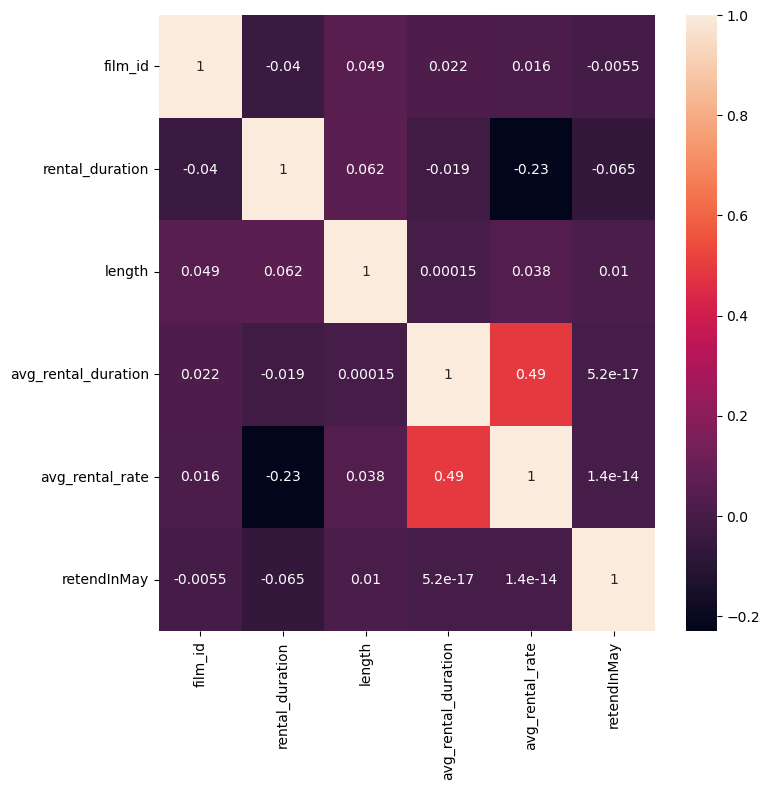

In [10]:
corr_matrix=data.corr()  # default
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [11]:
data['Category'] = data['rating'].apply(lambda x: 'Adults Only' if x == 'NC-17'
                                                       else 'Mature' if x == 'R'
                                                       else 'General' if x == 'PG'
                                                       else 'Kids' if x == 'G'
                                                       else 'Teenagers' if x == 'PG-13'
                                                       else 'Unknown')

# Start modell

In [12]:
# Need to X-y-split AND train-test-split BEFORE I apply transformations, 
# then train transformation on training set only
y = data['retendInMay']
X = data.drop(['retendInMay','film_id','title'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [14]:
X_train_norm.columns = X_train_num.columns
X_train_norm.head()

,rental_duration,length,avg_rental_duration,avg_rental_rate
0,0.50,0.769784,0.40,0.400
1,0.75,0.151079,0.50,0.000
2,0.00,0.258993,0.50,0.400
3,0.50,0.223022,0.35,0.425
4,0.25,0.733813,0.45,0.150


In [15]:
X_train_categorical = X_train.select_dtypes(include = np.object)
X_train_cat = pd.get_dummies(X_train_categorical, 
                             columns=['rating','special_features','Category'],
                             drop_first=True)
X_train_cat.head()

/var/folders/0v/17715kfs38508b6c7dzmsg8h0000gn/T/ipykernel_11486/1602687991.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_categorical = X_train.select_dtypes(include = np.object)


,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Commentaries,"special_features_Commentaries,Behind the Scenes","special_features_Commentaries,Deleted Scenes","special_features_Commentaries,Deleted Scenes,Behind the Scenes",special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",...,"special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes",Category_General,Category_Kids,Category_Mature,Category_Teenagers
46,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
789,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
722,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
283,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [16]:
X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)

In [17]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='auto').fit(X_train_transformed, y_train)

In [18]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [19]:
# for categoricals
X_test_categorical = X_test.select_dtypes(include = np.object)
X_test_cat = pd.get_dummies(X_test_categorical, 
                            columns=['rating','special_features','Category'],
                            drop_first=True)
# verify that dummies columns are in the same order and that the same column was dropped
display(list(zip(list(X_train_cat.columns),list(X_test_cat.columns))))
# not needed if you treat each dataframe with one_hot_encoder and save the encode (and the column names)

#X_test_cat.head()

/var/folders/0v/17715kfs38508b6c7dzmsg8h0000gn/T/ipykernel_11486/2465513327.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_categorical = X_test.select_dtypes(include = np.object)


[('rating_NC-17', 'rating_NC-17'),
 ('rating_PG', 'rating_PG'),
 ('rating_PG-13', 'rating_PG-13'),
 ('rating_R', 'rating_R'),
 ('special_features_Commentaries', 'special_features_Commentaries'),
 ('special_features_Commentaries,Behind the Scenes',
  'special_features_Commentaries,Behind the Scenes'),
 ('special_features_Commentaries,Deleted Scenes',
  'special_features_Commentaries,Deleted Scenes'),
 ('special_features_Commentaries,Deleted Scenes,Behind the Scenes',
  'special_features_Commentaries,Deleted Scenes,Behind the Scenes'),
 ('special_features_Deleted Scenes', 'special_features_Deleted Scenes'),
 ('special_features_Deleted Scenes,Behind the Scenes',
  'special_features_Deleted Scenes,Behind the Scenes'),
 ('special_features_Trailers', 'special_features_Trailers'),
 ('special_features_Trailers,Behind the Scenes',
  'special_features_Trailers,Behind the Scenes'),
 ('special_features_Trailers,Commentaries',
  'special_features_Trailers,Commentaries'),
 ('special_features_Trailer

In [20]:
X_test_transformed = np.concatenate([X_test_norm, X_test_cat], axis=1)

In [22]:
X_test_transformed

array([[0.        , 0.37410072, 0.48605685, ..., 0.        , 1.        ,
        0.        ],
       [0.75      , 0.96402878, 0.9       , ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.31654676, 0.4       , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [1.        , 0.27338129, 0.26667   , ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.29496403, 0.45      , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.4028777 , 0.2       , ..., 0.        , 1.        ,
        0.        ]])

In [23]:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.7

In [24]:
print(y_test.value_counts())

1    138
0     62
Name: retendInMay, dtype: int64


In [25]:
pd.Series(predictions).value_counts()

1    198
0      2
dtype: int64

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  2,  60],
       [  0, 138]])